# PJM Load Hourly Consumption Forecasting with ARIMA Model

## Load the PJM_Load_hourly dataset

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the PJM_Load_hourly dataset
data_path = r"dataset.csv"
data = pd.read_csv(data_path)

# Strip any leading/trailing spaces from column names and rename the first column to 'Datetime'
data.columns = data.columns.str.strip()
data = data.rename(columns={data.columns[0]: 'Datetime'})

# Display basic information and the first few rows
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32896 entries, 0 to 32895
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Datetime     32896 non-null  object 
 1   PJM_Load_MW  32896 non-null  float64
dtypes: float64(1), object(1)
memory usage: 514.1+ KB
None
              Datetime  PJM_Load_MW
0  1998-12-31 01:00:00      29309.0
1  1998-12-31 02:00:00      28236.0
2  1998-12-31 03:00:00      27692.0
3  1998-12-31 04:00:00      27596.0
4  1998-12-31 05:00:00      27888.0


## Convert 'Datetime' to datetime object and set it as the index

In [26]:
# Convert 'Datetime' to datetime object and set it as the index
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)


# Check the first few rows of the resampled data
print(data.head())

                     PJM_Load_MW
Datetime                        
1998-12-31 01:00:00      29309.0
1998-12-31 02:00:00      28236.0
1998-12-31 03:00:00      27692.0
1998-12-31 04:00:00      27596.0
1998-12-31 05:00:00      27888.0


## Check for Missing Values

In [27]:
# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing Values:")
print(missing_values)


Missing Values:
PJM_Load_MW    0
dtype: int64


## Plot the Overall Trend and Seasonality

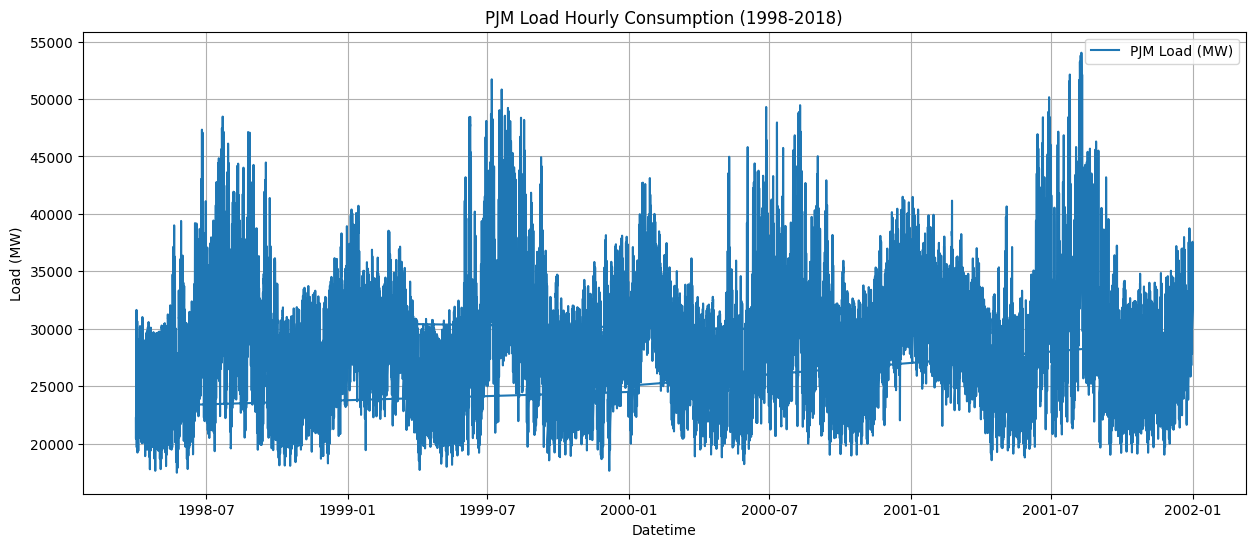

In [28]:
# Plot the overall trend and seasonality
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['PJM_Load_MW'], label='PJM Load (MW)')
plt.xlabel('Datetime')
plt.ylabel('Load (MW)')
plt.title('PJM Load Hourly Consumption (1998-2018)')
plt.legend()
plt.grid(True)
plt.show()

## Normalize the Data Using Min-Max Scaling

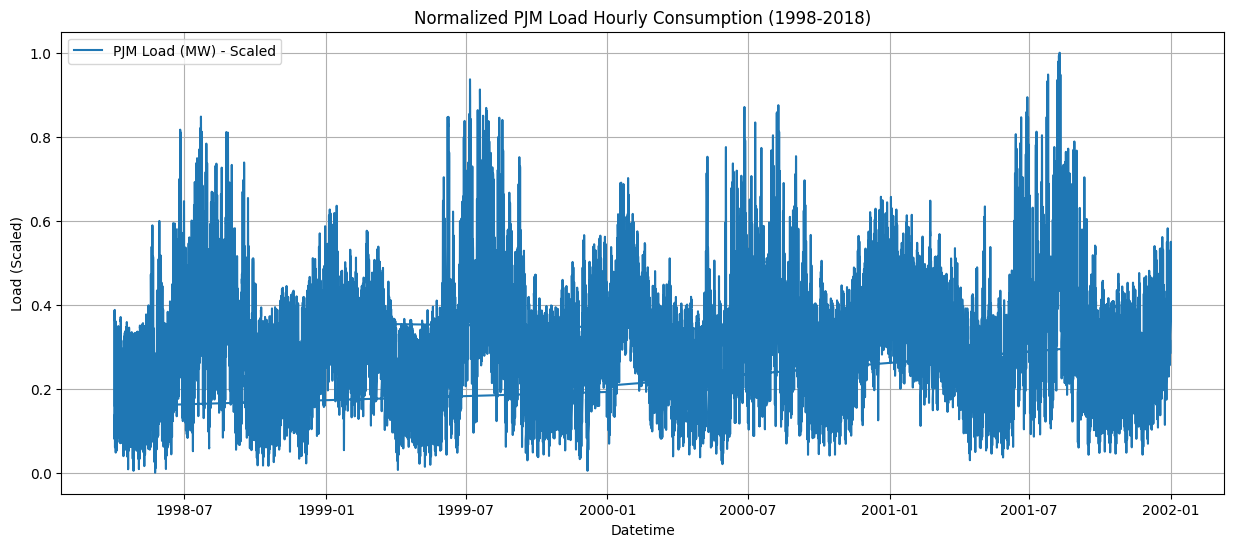

In [29]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
data['PJM_Load_MW_Scaled'] = scaler.fit_transform(data[['PJM_Load_MW']])

# Plot the scaled data
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['PJM_Load_MW_Scaled'], label='PJM Load (MW) - Scaled')
plt.xlabel('Datetime')
plt.ylabel('Load (Scaled)')
plt.title('Normalized PJM Load Hourly Consumption (1998-2018)')
plt.legend()
plt.grid(True)
plt.show()

## Apply Differencing to Achieve Stationarity

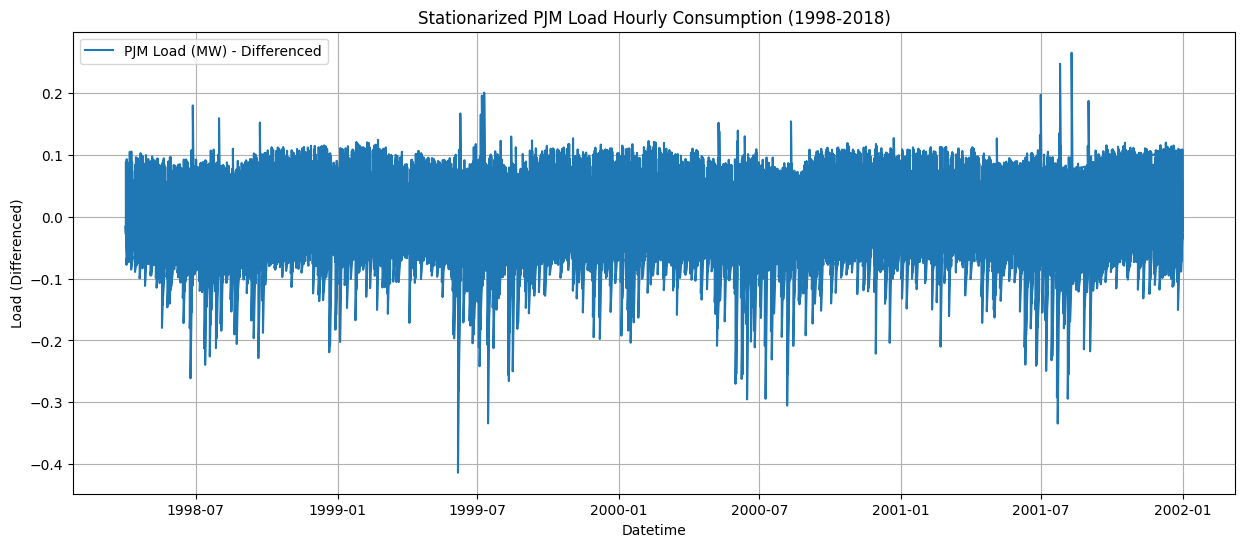

In [30]:
# Apply differencing to achieve stationarity
data['PJM_Load_MW_Diff'] = data['PJM_Load_MW_Scaled'].diff()

# Plot the differenced data
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['PJM_Load_MW_Diff'], label='PJM Load (MW) - Differenced')
plt.xlabel('Datetime')
plt.ylabel('Load (Differenced)')
plt.title('Stationarized PJM Load Hourly Consumption (1998-2018)')
plt.legend()
plt.grid(True)
plt.show()

## Check Stationarity Using the Augmented Dickey-Fuller (ADF) Test

In [31]:
# Check the stationarity using the Augmented Dickey-Fuller (ADF) test
adf_test = adfuller(data['PJM_Load_MW_Diff'].dropna())

# Extract the test results
adf_results = {
    'ADF Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Used Lags': adf_test[2],
    'Number of Observations': adf_test[3],
    'Critical Values': adf_test[4]
}

# Display the ADF test results
print("\nADF Test Results:")
for key, value in adf_results.items():
    print(f"{key}: {value}")

# Interpretation
if adf_test[1] < 0.05:
    print("\nThe time series is stationary based on the ADF test.")
else:
    print("\nThe time series is not stationary based on the ADF test.")


ADF Test Results:
ADF Statistic: -24.77364027308919
p-value: 0.0
Used Lags: 52
Number of Observations: 32842
Critical Values: {'1%': -3.4305491295045205, '5%': -2.861628010138159, '10%': -2.566816845062138}

The time series is stationary based on the ADF test.


In [32]:
data.columns

Index(['PJM_Load_MW', 'PJM_Load_MW_Scaled', 'PJM_Load_MW_Diff'], dtype='object')

## Train-Test Split and ARIMA Model Implementation

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning

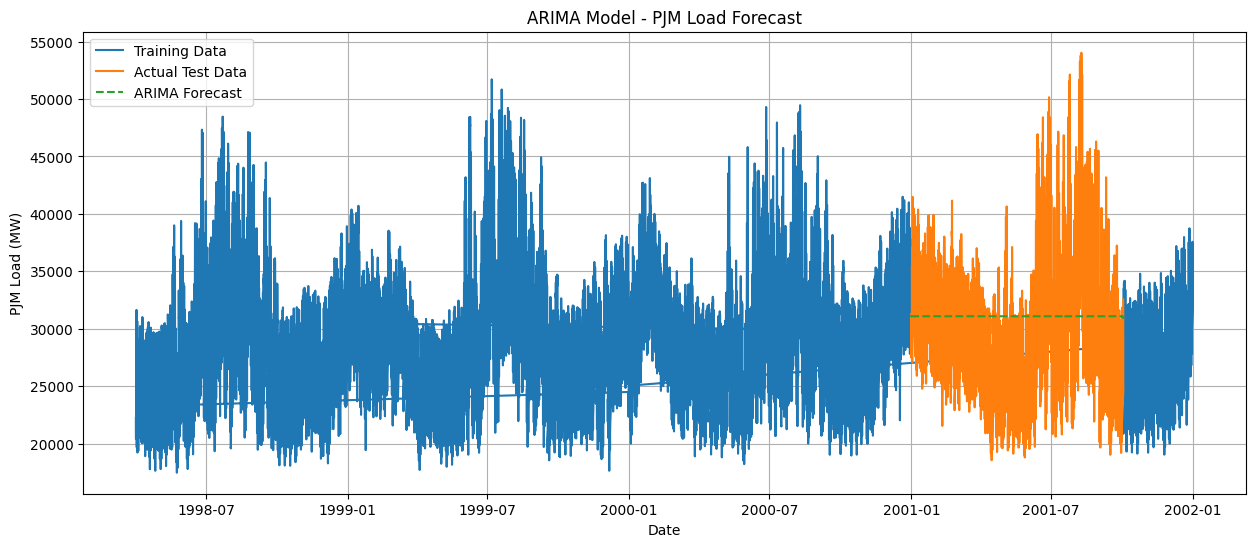

In [33]:
# Select only the 'PJM_Load_MW' column for ARIMA modeling
data = data['PJM_Load_MW']

# Split into training and testing sets (80% train, 20% test)
split_index = int(0.8 * len(data))
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# Train an ARIMA model (order determined by prior analysis)
model = ARIMA(train_data, order=(5, 1, 0))
arima_result = model.fit()

# Forecast the values
forecast = arima_result.forecast(steps=len(test_data))
forecast_index = test_data.index

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(forecast_index, forecast, label='ARIMA Forecast', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('PJM Load (MW)')
plt.title('ARIMA Model - PJM Load Forecast')
plt.grid(True)
plt.show()


## Calculate Evaluation Metrics

In [34]:
# Calculate evaluation metrics
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, forecast)

print("\nARIMA Model Evaluation Metrics:")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


ARIMA Model Evaluation Metrics:
MSE: 37839322.03982923
RMSE: 6151.367493478928
MAE: 4779.286066575401


In [35]:
import pickle
with open('arima_model.pkl', 'wb') as pkl:
    pickle.dump(arima_result, pkl)

# # To download the file to your local machine
# from google.colab import files
# files.download('arima_model.pkl')
